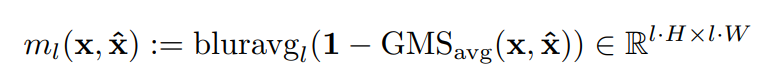

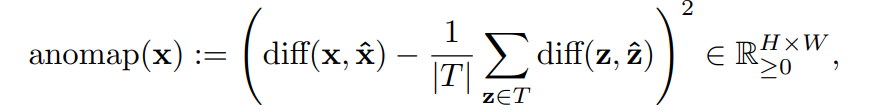

In [16]:
import torch
import torch.nn.functional as F
import math
from msgms import MSGMSLoss
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
from dataset import MVTecAD_loader
from model import InTra
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def create_gaussian_kernel(kernel_size, sigma):
    """Create a Gaussian kernel."""
    gauss = torch.tensor([math.exp(-x**2 / (2 * sigma**2)) for x in range(-kernel_size//2 + 1, kernel_size//2 + 1)])
    gauss = gauss / gauss.sum()
    gauss = gauss.view(1, -1) * gauss.view(-1, 1)
    return gauss.view(1, 1, kernel_size, kernel_size)

def apply_averaging_and_gaussian_filter(input_tensor, scale_factor, gauss_kernel_size=7, gauss_sigma=2):
    # Original spatial dimensions
    original_size = input_tensor.shape[-2:]

    # Create a uniform averaging kernel, adjusting for channel dimension
    channels = input_tensor.size(1)
    avg_kernel = torch.ones(channels, 1, scale_factor, scale_factor) / (scale_factor**2)
    avg_kernel = avg_kernel.to(input_tensor.device)

    # Apply convolution with stride equal to scale factor (for downsampling)
    downsampled_tensor = F.conv2d(input_tensor, avg_kernel, stride=scale_factor, padding=0, groups=channels)

    # Create Gaussian kernel
    gauss_kernel = create_gaussian_kernel(gauss_kernel_size, gauss_sigma).to(input_tensor.device)
    gauss_kernel = gauss_kernel.repeat(channels, 1, 1, 1)

    # Apply Gaussian blur
    smoothed_tensor = F.conv2d(downsampled_tensor, gauss_kernel, padding=gauss_kernel_size // 2, groups=channels)

    # Resize to original dimensions using bilinear interpolation
    resized_tensor = F.interpolate(smoothed_tensor, size=original_size, mode='bilinear', align_corners=False)

    return resized_tensor

def avg_multiscale(input_tensor, scale_factors=[1/2,1/4], gauss_kernel_size=7, gauss_sigma=2):
    smoothed_tensors = []
    for scale_factor in scale_factors:
        smoothed_tensors.append(apply_averaging_and_gaussian_filter(input_tensor, scale_factor, gauss_kernel_size, gauss_sigma))
    stacked_tensor = torch.stack(smoothed_tensors, dim=0)
    diff = torch.mean(stacked_tensor, dim=0)   
    return diff

# get some metrics of a tensor
def met(tensor):
    return (f"{{'Max': {tensor.max().item():.2f},'Min': {tensor.min().item():.2f},'Mean': {tensor.mean().item():.2f},"f"'Sd': {tensor.std().item():.2f},"f"'Median': {tensor.median().item():.2f},"f"'Sum': {tensor.sum().item():.2f},"f"'Product': {tensor.prod().item():.2f}}}")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])



def process_and_plot_tensors(image_tensor1, image_tensor1_pred, image_tensor2, image_tensor2_pred, mean_z_diff):
    msgms = MSGMSLoss()

    # Process the first pair of tensors
    loss1, map1 = msgms(image_tensor1.unsqueeze(0), image_tensor1_pred.unsqueeze(0))
    if mean_z_diff is not  None:

        diff1 = avg_multiscale(map1, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)-mean_z_diff
    else:
        diff1 = avg_multiscale(map1, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)
        
    diff_squared1 = diff1**2

    # Process the second pair of tensors
    loss2, map2 = msgms(image_tensor2.unsqueeze(0), image_tensor2_pred.unsqueeze(0))
    if mean_z_diff is not  None:
        diff2 = avg_multiscale(map2, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)-mean_z_diff
    else:
        
        diff2 = avg_multiscale(map2, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)
    diff_squared2 = diff2**2

    # Plotting
    fig, axs = plt.subplots(2, 4, figsize=(10, 10))
    axs[0, 0].imshow(image_tensor1.permute(1, 2, 0))
    axs[0, 0].set_title('Good')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(image_tensor1_pred.permute(1, 2, 0))
    axs[0, 1].set_title('Good 1 Prediction')
    axs[0, 1].axis('off')

    axs[0, 2].imshow(map1.squeeze(0).permute(1, 2, 0))
    axs[0, 2].set_title('msgms map')
    axs[0, 2].axis('off')

    axs[0, 3].imshow(diff_squared1.squeeze(0).permute(1, 2, 0))
    axs[0, 3].set_title('Anomap')
    axs[0, 3].axis('off')

    axs[1, 0].imshow(image_tensor2.permute(1, 2, 0))
    axs[1, 0].set_title('Anomaly 2')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(image_tensor2_pred.permute(1, 2, 0))
    axs[1, 1].set_title('Anomaly 2 Prediction')
    axs[1, 1].axis('off')

    axs[1, 2].imshow(map2.squeeze(0).permute(1, 2, 0))
    axs[1, 2].set_title('msgms map')
    axs[1, 2].axis('off')

    axs[1, 3].imshow(diff_squared2.squeeze(0).permute(1, 2, 0))
    axs[1, 3].set_title('Anomaly 2 Prediction')
    axs[1, 3].axis('off')

    plt.tight_layout()
    plt.show()
    
def get_mean_Z(RES_PATH,IMG_PATH,ano_class='cable'):
    model = InTra(grid_size_max=int(256/16)).to(device)
    model_state_dict = torch.load(os.path.join(RES_PATH, 'model_best.nn'), map_location='cuda') # last nn
    model.load_state_dict(model_state_dict)
    model.eval()        
    
    train_loader, _ = MVTecAD_loader(IMG_PATH, (256,256), 1, 1, num_workers=24, is_inference=True,Z_score=True)
    
    # get the mean of the msgms map of the training set
    with torch.no_grad():
        msgms_map_list = []
        for data, label in train_loader:
            data = data.to(device)
            _, _, _, msgms_map =  model._process_one_image(data)
            msgms_map_list.append(msgms_map)
        
        msgms_map_stacked = torch.vstack(msgms_map_list)
        msgms_map_stacked = torch.mean(msgms_map_stacked, dim=0, keepdim=True)

    torch.save(msgms_map_stacked, f'{ano_class}_mean_Z.pt')    
    
    
# # Example usage
# input_tensor = torch.randn(5, 1, 20, 20)  # Batch size of 5, 1 channel, 20x20 dimensions
# final = avg_multiscale(input_tensor, scale_factors=[2, 4], gauss_kernel_size=5, gauss_sigma=2)
# print(final.shape)  # Expected shape: (5, 1, 20, 20)

RES_PATH=f'/home/bule/projects/inpainting-transformer/ckpt'
IMG_PATH='/home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/cable'

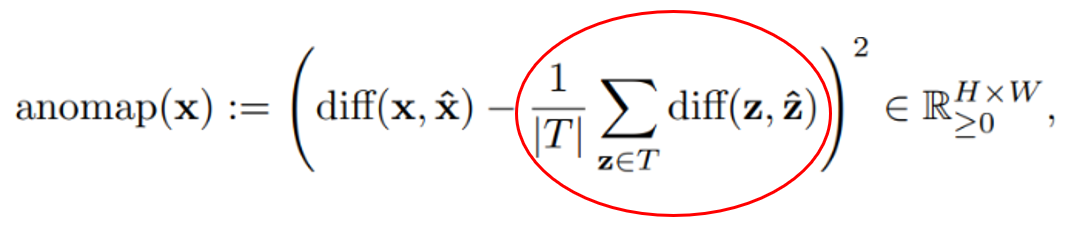

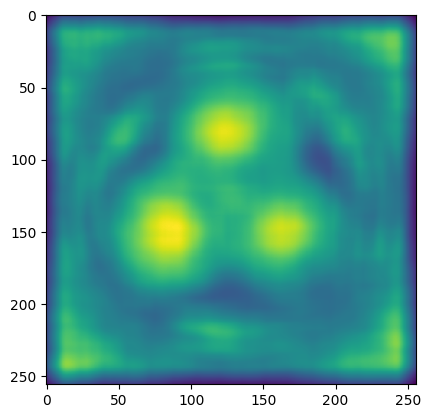

In [2]:
# mean from the training set
# get_mean_Z(RES_PATH,IMG_PATH,ano_class='cable') # calculation and save
mean_z_diff = torch.load('cable_mean_Z.pt').cpu()
plt.imshow(mean_z_diff.squeeze(0).permute(1, 2, 0))

In [13]:

image1 = Image.open('/home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/cable/train/good/005.png')
image_tensor1 = transform(image1)

image2 = Image.open('/home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection/cable/test/missing_cable/005.png')
image_tensor2 = transform(image2)

randomTensor = torch.randn(1, 3, 256, 256)
randomTensor = (randomTensor - randomTensor.min()) / (randomTensor.max() - randomTensor.min())


print(met(image_tensor1))
print(met(image_tensor2))
print(met(randomTensor))


{'Max': 1.00,'Min': 0.04,'Mean': 0.38,'Sd': 0.21,'Median': 0.34,'Sum': 75667.11,'Product': 0.00}
{'Max': 1.00,'Min': 0.05,'Mean': 0.40,'Sd': 0.23,'Median': 0.36,'Sum': 78860.31,'Product': 0.00}
{'Max': 1.00,'Min': 0.00,'Mean': 0.48,'Sd': 0.11,'Median': 0.48,'Sum': 94338.29,'Product': 0.00}


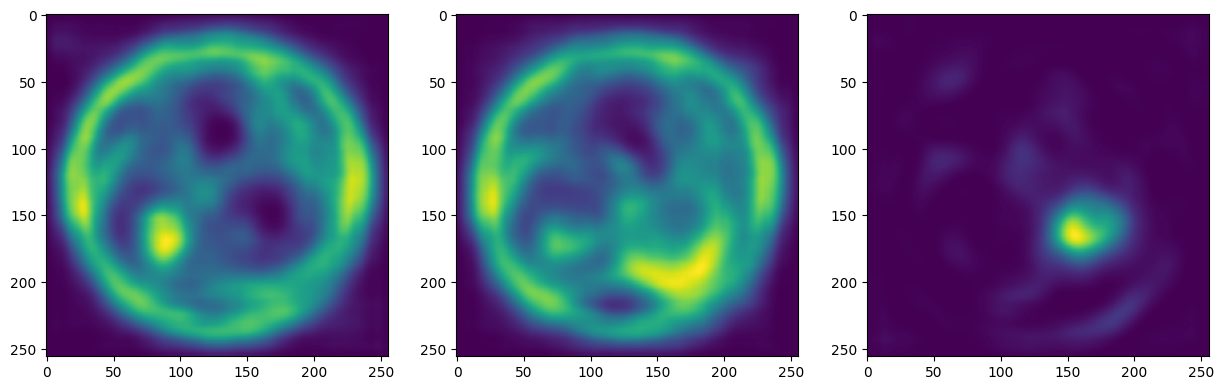

{'Max': 0.11,'Min': 0.00,'Mean': 0.04,'Sd': 0.03,'Median': 0.03,'Sum': 2393.84,'Product': 0.00}
{'Max': 0.12,'Min': 0.00,'Mean': 0.04,'Sd': 0.03,'Median': 0.04,'Sum': 2800.53,'Product': 0.00}
{'Max': 0.28,'Min': 0.00,'Mean': 0.01,'Sd': 0.03,'Median': 0.00,'Sum': 765.89,'Product': 0.00}


In [4]:
msgms=MSGMSLoss()
loss, map =msgms(image_tensor1.unsqueeze(0),randomTensor)
diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)-mean_z_diff
diff_squared1 = diff**2

loss, map =msgms(image_tensor2.unsqueeze(0),randomTensor)
diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)-mean_z_diff
diff_squared2 = diff**2

# same image , difference should be zero
loss, map =msgms(image_tensor1.unsqueeze(0),image_tensor2.unsqueeze(0))
diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)-mean_z_diff
diff_squared3 = diff**2

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(diff_squared1.squeeze(0).permute(1, 2, 0))
axs[1].imshow(diff_squared2.squeeze(0).permute(1, 2, 0))
axs[2].imshow(diff_squared3.squeeze(0).permute(1, 2, 0))
plt.show()


print(met(diff_squared1))
print(met(diff_squared2))
print(met(diff_squared3))


## Real Predicitons


{'Max': 1.00,'Min': 0.04,'Mean': 0.41,'Sd': 0.21,'Median': 0.36,'Sum': 79937.95,'Product': 0.00}
{'Max': 1.00,'Min': 0.05,'Mean': 0.43,'Sd': 0.22,'Median': 0.38,'Sum': 83903.84,'Product': 0.00}


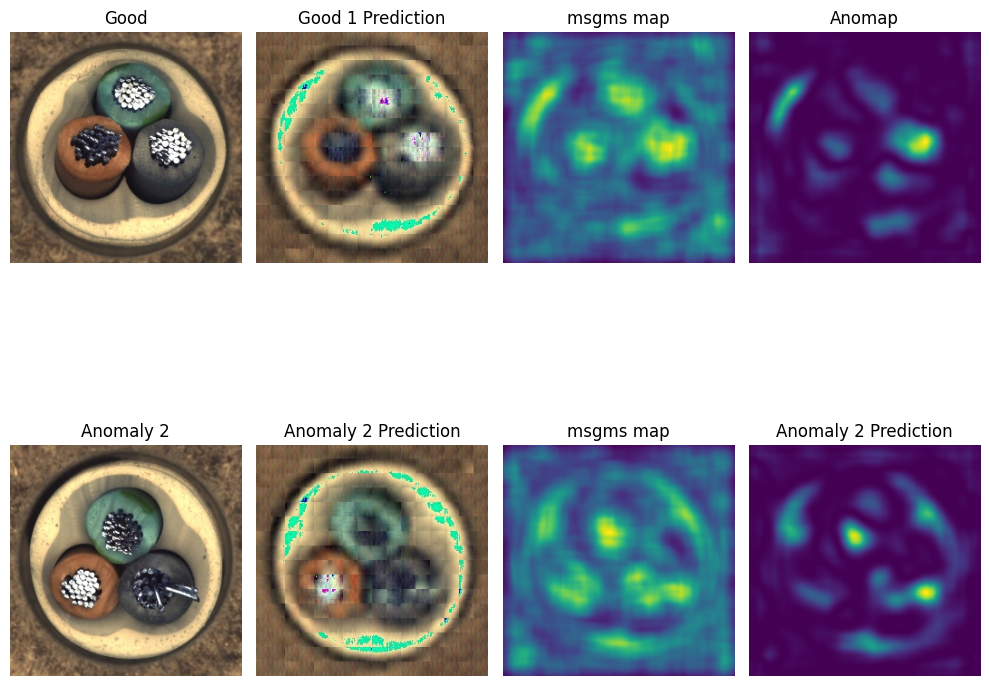

In [18]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Good
good_real = Image.open('/home/bule/projects/inpainting-transformer/ckpt/results/good_002_image.jpg')
image_tensor1 = transform(good_real)

good_pred = Image.open('/home/bule/projects/inpainting-transformer/ckpt/results/good_002_recon.jpg')
image_tensor1_pred = transform(good_pred)

## anomaly
anomaly_real = Image.open('/home/bule/projects/inpainting-transformer/ckpt/results/bent_wire_003_image.jpg')
image_tensor2 = transform(anomaly_real)

anomaly_pred= Image.open('/home/bule/projects/inpainting-transformer/ckpt/results/bent_wire_003_recon.jpg')
image_tensor2_pred = transform(anomaly_pred)


print(met(image_tensor1))
print(met(image_tensor2))


process_and_plot_tensors(image_tensor1, image_tensor1_pred, image_tensor2, image_tensor2_pred,mean_z_diff=mean_z_diff)

In [12]:
RESULTS_PATH='/home/bule/projects/inpainting-transformer/ckpt/results'

types=['bent_wire','cable_swap','combined','cut_inner_insulation','cut_outer_insulation','missing_cable','missing_wire','poke_insulation']
good_real=[(os.path.join(RESULTS_PATH,img),img,img[:-10] ) for img  in os.listdir(RESULTS_PATH) if 'good' in img and 'image'in img]
good_pred=[(os.path.join(RESULTS_PATH,img),img,img[:-10] ) for img  in os.listdir(RESULTS_PATH) if 'good' in img and 'recon'in img]

ano_real=[(os.path.join(RESULTS_PATH,img),img,img[:-10] ) for img  in os.listdir(RESULTS_PATH) if 'good' not in img and 'image'in img]
ano_pred=[(os.path.join(RESULTS_PATH,img),img,img[:-10]) for img  in os.listdir(RESULTS_PATH) if 'good' not in img and 'recon'in img]

# pairs good and recon 
good_real_pred=[(real[0],pred[0]) for real in good_real for pred in good_pred if real[2]==pred[2]]
ano_real_pred=[(real[0],pred[0]) for real in ano_real for pred in ano_pred if real[2]==pred[2]]

len(good_real_pred),len(ano_real_pred)

(58, 92)

In [7]:
good_max=[]
ano_max=[]

good_mean=[]
ano_mean=[]

loss_good=[]
loss_ano=[]

msgms=MSGMSLoss()

for paths in good_real_pred:
    image_tensor1 = transform(Image.open(paths[0]))
    image_tensor2 = transform(Image.open(paths[1]))
    
    loss, map =msgms(image_tensor1.unsqueeze(0),image_tensor2.unsqueeze(0))
    diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)#-mean_z_diff
    diff_squared1 = diff**2
    good_max.append(diff_squared1.max().item())
    good_mean.append(diff_squared1.mean().item())
    loss_good.append(loss.item())
    
for paths in ano_real_pred:
    image_tensor1 = transform(Image.open(paths[0]))
    image_tensor2 = transform(Image.open(paths[1]))  
    
    loss, map =msgms(image_tensor1.unsqueeze(0),image_tensor2.unsqueeze(0))
    diff = avg_multiscale(map, scale_factors=[2, 4], gauss_kernel_size=21, gauss_sigma=2)#-mean_z_diff
    diff_squared1 = diff**2
    ano_max.append(diff_squared1.max().item())
    ano_mean.append(diff_squared1.mean().item())
    loss_ano.append(loss.item())
    

In [11]:
len(good)

NameError: name 'good' is not defined

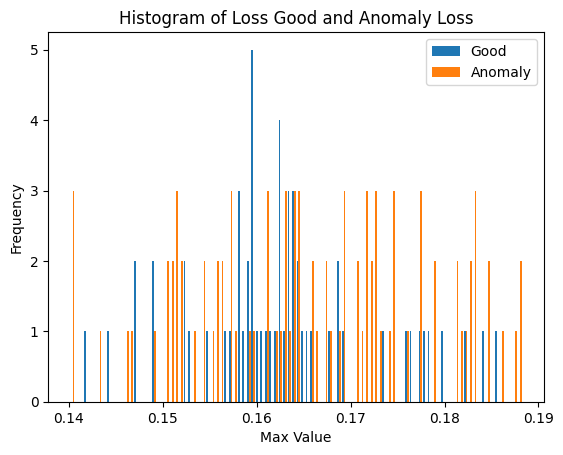

In [8]:
plt.hist([loss_good, loss_ano], bins=100, label=['Good', 'Anomaly'])
plt.xlabel('Max Value')
plt.ylabel('Frequency')
plt.title('Histogram of Loss Good and Anomaly Loss')
plt.legend()
plt.show()

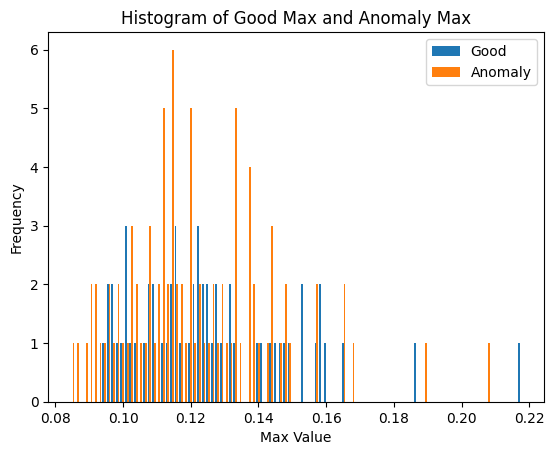

In [9]:
import matplotlib.pyplot as plt

plt.hist([good_max, ano_max], bins=100, label=['Good', 'Anomaly'])
plt.xlabel('Max Value')
plt.ylabel('Frequency')
plt.title('Histogram of Good Max and Anomaly Max')
plt.legend()
plt.show()


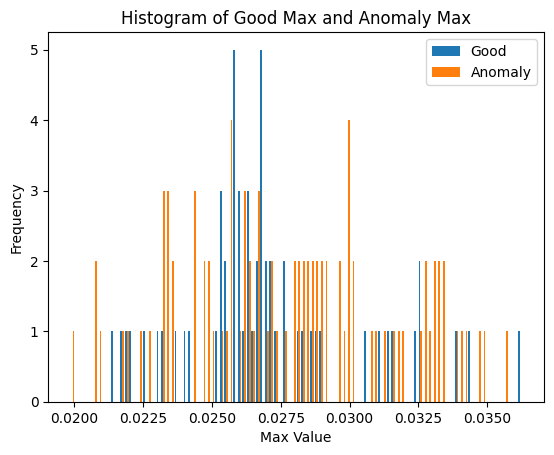

In [10]:
import matplotlib.pyplot as plt

plt.hist([good_mean, ano_mean], bins=100, label=['Good', 'Anomaly'])
plt.xlabel('Max Value')
plt.ylabel('Frequency')
plt.title('Histogram of Good Max and Anomaly Max')
plt.legend()
plt.show()


## conclusions
darker regions with lowe3r values get higher score when the reconstruction is random 



